# Model Development Notebook

This notebook was developed using Google Colab to take advantage of GPU access for model training.

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load('goemotions', with_info=True, as_supervised=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteCVI3EM/goemotions-train.tfrecord


  0%|          | 0/43410 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteCVI3EM/goemotions-validation.tfrecord


  0%|          | 0/5426 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/goemotions/0.1.0.incompleteCVI3EM/goemotions-test.tfrecord


  0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [5]:
dataset

{'test': <PrefetchDataset element_spec={'admiration': TensorSpec(shape=(), dtype=tf.bool, name=None), 'amusement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'anger': TensorSpec(shape=(), dtype=tf.bool, name=None), 'annoyance': TensorSpec(shape=(), dtype=tf.bool, name=None), 'approval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'caring': TensorSpec(shape=(), dtype=tf.bool, name=None), 'comment_text': TensorSpec(shape=(), dtype=tf.string, name=None), 'confusion': TensorSpec(shape=(), dtype=tf.bool, name=None), 'curiosity': TensorSpec(shape=(), dtype=tf.bool, name=None), 'desire': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disappointment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disapproval': TensorSpec(shape=(), dtype=tf.bool, name=None), 'disgust': TensorSpec(shape=(), dtype=tf.bool, name=None), 'embarrassment': TensorSpec(shape=(), dtype=tf.bool, name=None), 'excitement': TensorSpec(shape=(), dtype=tf.bool, name=None), 'fear': TensorSpec(shape=(), dtype=tf.bo

In [6]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

In [7]:
for element in train_data:
  print(element['comment_text'])
  break

tf.Tensor(b"It's just wholesome content, from questionable sources", shape=(), dtype=string)


In [8]:
LABELS = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral',
]

In [9]:
from tqdm.notebook import tqdm_notebook

def prepare_data(LABELS, data):

  comments = []
  print('Preparing comments')
  for element in tqdm_notebook(data):
    comments.append(element['comment_text'].numpy().decode('utf8'))
  comments = np.array(comments)

  labels = []
  print('Preparing labels')
  for element in tqdm_notebook(data):
    label = []
    for l in LABELS:
      label.append(element[l].numpy())
    labels.append(label)

  labels = np.array(labels)
  labels = labels.astype('int')

  return comments, labels

In [10]:
train_comments, train_labels = prepare_data(LABELS, train_data)

Preparing comments


  0%|          | 0/43410 [00:00<?, ?it/s]

Preparing labels


  0%|          | 0/43410 [00:00<?, ?it/s]

In [11]:
val_comments, val_labels = prepare_data(LABELS, val_data)

Preparing comments


  0%|          | 0/5426 [00:00<?, ?it/s]

Preparing labels


  0%|          | 0/5426 [00:00<?, ?it/s]

In [12]:
test_comments, test_labels = prepare_data(LABELS, test_data)

Preparing comments


  0%|          | 0/5427 [00:00<?, ?it/s]

Preparing labels


  0%|          | 0/5427 [00:00<?, ?it/s]

In [13]:
print(train_comments.shape)
print(train_labels.shape)

(43410,)
(43410, 28)


In [14]:
vocab_size = 10000
embedding_dim = 100
max_length = 30
trunc_type = 'post'
oov_token = '<oov>'

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_comments)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(train_comments)
padded_sequences = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_comments)
padded_val_sequences = pad_sequences(val_sequences, maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_comments)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

In [53]:
from joblib import dump

dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [16]:
def create_glove_embeddings(file_path):

  embeddings_index = {}
  glove_file = open(file_path, encoding='utf8')
  for line in glove_file:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  glove_file.close()

  print('Found {} word vectors.'.format(len(embeddings_index)))

  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in word_index.items():
      if i < vocab_size:
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector

  print('Embedding matrix shape:', embedding_matrix.shape)
  return embedding_matrix

embeddings_matrix = create_glove_embeddings(file_path='./drive/MyDrive/glove.6B.100d.txt')

Found 400000 word vectors.
Embedding matrix shape: (10000, 100)


In [43]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                                                              weights=[embeddings_matrix], trainable=False),
                                    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
                                    tf.keras.layers.LSTM(128),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(28, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 100)           1000000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 28)                1820      
                                                                 
Total params: 1,127,324
Trainable params: 127,324
Non-trainable params: 1,000,000
_________________________________________________________________


In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01)

In [47]:
history = model.fit(padded_sequences,
                    train_labels,
                    validation_data=(padded_val_sequences, val_labels),
                    epochs=50,
                    callbacks=early_stopping,
                    batch_size=128)

Epoch 1/50
340/340 [==============================] - 5s 16ms/step - loss: 0.1388 - accuracy: 0.3545 - val_loss: 0.1279 - val_accuracy: 0.3988
Epoch 2/50
340/340 [==============================] - 5s 14ms/step - loss: 0.1249 - accuracy: 0.4141 - val_loss: 0.1163 - val_accuracy: 0.4493
Epoch 3/50
340/340 [==============================] - 5s 14ms/step - loss: 0.1171 - accuracy: 0.4479 - val_loss: 0.1113 - val_accuracy: 0.4674
Epoch 4/50
340/340 [==============================] - 5s 14ms/step - loss: 0.1132 - accuracy: 0.4617 - val_loss: 0.1087 - val_accuracy: 0.4862
Epoch 5/50
340/340 [==============================] - 5s 14ms/step - loss: 0.1103 - accuracy: 0.4727 - val_loss: 0.1059 - val_accuracy: 0.4919
Epoch 6/50
340/340 [==============================] - 5s 13ms/step - loss: 0.1079 - accuracy: 0.4830 - val_loss: 0.1047 - val_accuracy: 0.4974
Epoch 7/50
340/340 [==============================] - 5s 13ms/step - loss: 0.1062 - accuracy: 0.4905 - val_loss: 0.1040 - val_accuracy: 0.5065

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


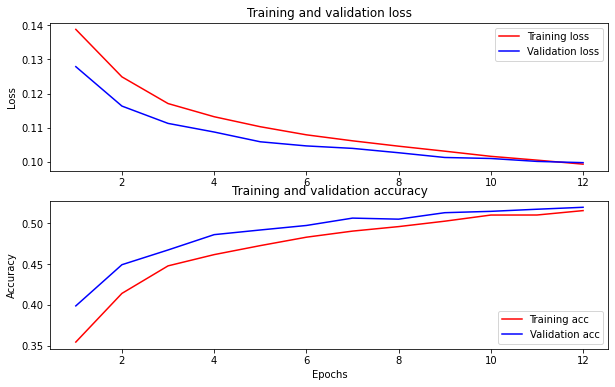

In [48]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [49]:
test_results = model.evaluate(padded_test_sequences, test_labels)

print('Test Accuracy:', test_results[1])

170/170 [==============================] - 1s 5ms/step - loss: 0.0999 - accuracy: 0.5053
Test Accuracy: 0.5052515268325806


In [51]:
from time import strftime, gmtime

prefix = 'baseline-glove-'
metric = str(round(test_results[1], 3))
model_name = prefix + strftime("%Y-%m-%d-%H-%M-%S", gmtime()) + '-test-acc-' + metric + '.h5'

model.save(model_name)
print('Model saved as', model_name)

Model saved as baseline-glove-2022-04-28-19-08-04-test-acc-0.505.h5
